In [1]:
from ultralytics import YOLO
import cv2
import torch
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
from shapely.geometry import Polygon, Point, box

In [2]:
img_path = '/home/estaid/dev/prediction_Car/data/images/frame_9691.jpg'
img_pil = Image.open(img_path)
img_np = np.array(img_pil)

model = YOLO('/home/estaid/dev/prediction_Car/yolov8x.pt')

top_left = (0, 440)  
bottom_left =  (0, 1514)    
bottom_right = (1677, 1514)  
top_right = (1677, 440)  

polygon_points = np.array([top_left, bottom_left, bottom_right, top_right], dtype=np.int32).reshape((-1, 1, 2))

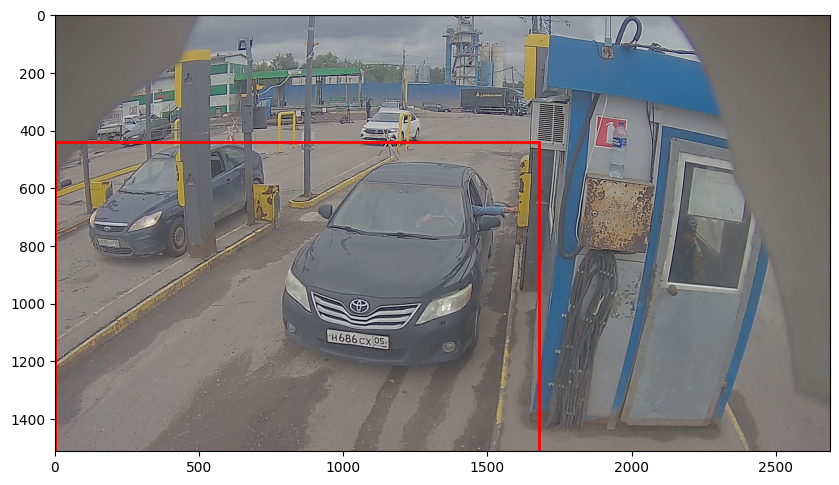

In [ ]:
image = Image.open(img_path)
img_array = np.asarray(image)
fig, ax = plt.subplots(figsize=(10, 10)) 
ax.imshow(img_array)
poly_patch = patches.Polygon([
    top_left, bottom_left, bottom_right, top_right
],
fill=False, edgecolor='red', linewidth=2)
ax.add_patch(poly_patch)
plt.savefig("output_with_roi.png")  
plt.show()                        



0: 384x640 1 bicycle, 5 cars, 1 truck, 44.7ms
Speed: 11.8ms preprocess, 44.7ms inference, 107.2ms postprocess per image at shape (1, 3, 384, 640)


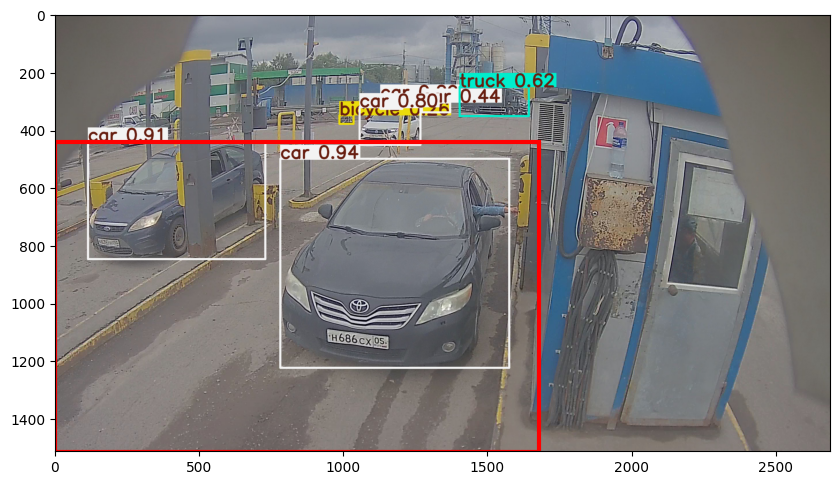

In [ ]:
results = model.predict(source = img_np)
polygon_points = np.array([top_left, bottom_left, bottom_right, top_right])
result_img = results[0].plot()
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(result_img)
poly = plt.Polygon(polygon_points, closed=True, edgecolor='red', facecolor='none', linewidth=3)
ax.add_patch(poly)
plt.show()


0: 384x640 1 bicycle, 5 cars, 1 truck, 224.1ms
Speed: 2.2ms preprocess, 224.1ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


[[781.6607055664062,
  498.1984558105469,
  1575.63232421875,
  1223.833984375,
  0.9446566700935364,
  2.0],
 [114.50959777832031,
  438.0544738769531,
  729.4635009765625,
  846.0122680664062,
  0.9094582200050354,
  2.0]]

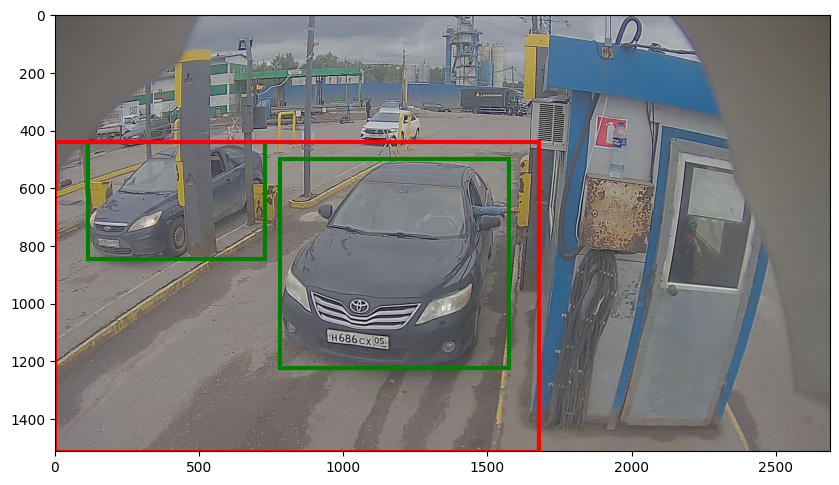

In [7]:
results = model.predict(source=img_np)
result = results[0]

roi_polygon = Polygon([top_left, bottom_left, bottom_right, top_right])

filtered_results = []

for r in result.boxes.data.tolist():
    x1, y1, x2, y2, conf, cls = map(float, r[:6])
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    
    bbox_poly = box(x1, y1, x2, y2)

    if roi_polygon.contains(Point(center_x, center_y)):
        filtered_results.append(r)

display(filtered_results)

filtered_boxes = np.array(filtered_results)


results_img = result.plot()
fig, ax = plt.subplots(figsize=(10, 10)) 

ax.imshow(img_pil) 

for r in filtered_boxes:
    x1, y1, x2, y2, _, _ = map(int, r[:6])
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='green', lw=3)
    ax.add_patch(rect)

# Добавляем полигон ROI поверх изображения
verts = list(roi_polygon.exterior.coords[:-1]) 
poly = patches.Polygon(verts, closed=True, edgecolor='red', facecolor="none", linewidth=3)
ax.add_patch(poly)

plt.show()

In [11]:
import cv2
from ultralytics import YOLO
from shapely.geometry import Polygon, Point, box
import numpy as np

MODEL_PATH = '/home/estaid/dev/prediction_Car/yolov8x.pt'
VIDEO_INPUT_PATH = '/home/estaid/dev/prediction_Car/data/cvtest.avi'
VIDEO_OUTPUT_PATH = 'output_video.mp4'

# ROI
TOP_LEFT = (0, 440)
BOTTOM_LEFT = (0, 1514)
BOTTOM_RIGHT = (1677, 1514)
TOP_RIGHT = (1677, 440)
ROI_POLYGON = Polygon([TOP_LEFT, BOTTOM_LEFT, BOTTOM_RIGHT, TOP_RIGHT])

MODEL = YOLO(MODEL_PATH)

# классы для детекции
CLASSES = (2, 7)

def draw_filtered_boxes(frame, filtered_results):
    """
    Функция рисует рамочки и надписи поверх кадра для фильтрованных результатов.
    :param frame: исходный кадр
    :param filtered_results: список объектов, прошедших фильтрацию
    """
    for r in filtered_results:
        x1, y1, x2, y2 = map(int, r[:4])
        conf = round(float(r[4]), 2)
        cls = int(r[5])
        
        color = (0, 255, 0)  #green
        thickness = 3
        font_scale = 2
        text_color = (0, 0, 255) #red
        
        # Рисуем рамочку вокруг объекта
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, thickness)
        
        # Пишем метку класса и уверенность
        label = f"{cls}: {conf}"
        cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, thickness)

def process_frame(frame):
    """
    Обрабатываем один кадр: выполняем детекцию, фильтруем и рисуем обнаруженные объекты.
    :param frame: входящий кадр
    :return: кадр с нарисованными объектами
    """
    global MODEL, CLASSES
    
    results = MODEL.predict(frame, classes=CLASSES)[0]
    
    # Фильтрация объектов по региону интереса
    filtered_results = []
    for r in results.boxes.data.tolist():
        x1, y1, x2, y2, conf, cls = map(float, r[:6])
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        # Проверяем центр рамки внутри ROI
        if ROI_POLYGON.contains(Point(center_x, center_y)):
            filtered_results.append(r)
    
    # Отображаем ограничивающие рамки и метки на кадре
    draw_filtered_boxes(frame, filtered_results)
    
    return frame

if __name__ == "__main__":
    cap = cv2.VideoCapture(VIDEO_INPUT_PATH)
    
    # Получаем характеристики видео
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Создаем объект VideoWriter для вывода результата
    out = cv2.VideoWriter(
        VIDEO_OUTPUT_PATH,
        cv2.VideoWriter_fourcc(*'mp4v'),
        fps,
        (width, height)
    )

    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        processed_frame = process_frame(frame)
        out.write(processed_frame)

    cap.release()
    out.release()


0: 384x640 2 cars, 1 truck, 12.6ms
Speed: 1.3ms preprocess, 12.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 11.9ms
Speed: 1.6ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 11.7ms
Speed: 1.4ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 12.0ms
Speed: 1.4ms preprocess, 12.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 12.1ms
Speed: 1.5ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 12.3ms
Speed: 1.4ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 11.1ms
Speed: 1.6ms preprocess, 11.1ms i